# Testing `Whirl2d` on Navier-Stokes solution with a body 

In [1]:
include(joinpath(Pkg.dir("whirl2d"), "src/Whirl2d.jl"))
import Whirl2d
import Whirl2d:@get
using PyPlot
@get Whirl2d (Systems, Grids, DualPatch, Bodies, TimeMarching, NavierStokes);

### Create a body

In [10]:
Npts = 50
len = 1
xcent = [0.0,0.0]
ang = 2π/3
b = Bodies.Plate(Npts,len,xcent,ang)

Body: number of points = 50, reference point = (0.0,0.0), rotation matrix = [-0.5 -0.866025; 0.866025 -0.5]


### Create a domain with this body in it

In [11]:
xmin = [-1.0,-1.0]
xmax = [3.0,1.0]
dom = Systems.DualDomain(xmin,xmax)
dom = Systems.add_body(dom,b)

Domain: xmin = [-1.0, -1.0], xmax = [3.0, 1.0]
number of bodies = 1
Body: number of points = 50, reference point = (0.0,0.0), rotation matrix = [-0.5 -0.866025; 0.866025 -0.5]



#### Add a filling dual grid to this domain
The boundaries of the domain coincide with the boundaries of the dual grid

In [12]:
Δx = 0.02
dom = Systems.add_grid(dom,Δx)

Domain: xmin = [-1.0, -1.0], xmax = [3.0, 1.0]
number of bodies = 1
Body: number of points = 50, reference point = (0.0,0.0), rotation matrix = [-0.5 -0.866025; 0.866025 -0.5]

Grid: number of cells = (200,100), Δx = 0.02, xmin = [-1.0, -1.0], xmax = [3.0, 1.0]



### Set the physical and time parameters

In [13]:
Re = 200
physparams = NavierStokes.set_freestream([1.0,0.0])
NavierStokes.set_Re!(physparams,Re)
Δt = min(0.5*Δx,Δx^2*Re)

α = Δt/(Re*Δx^2)
tparams = TimeMarching.TimeParams(Δt,TimeMarching.RK31())

params = (physparams,α)

(Whirl2d.NavierStokes.PhysParams([1.0, 0.0], 200.0), 0.125)

### Compute the grid and body operators
This fills in the LGF and integrating factor tables, computes the interpolation/regularization operators, computes the Schur complement operators and factorizes them, and defines the operators needed for calling the HERK

In [14]:
@time ops = NavierStokes.set_operators_body!(dom,params);
A⁻¹,L⁻¹,B₁ᵀ,B₂!,S⁻¹,S₀⁻¹,r₁,r₂ = ops

(Whirl2d.NavierStokes.A⁻¹, Whirl2d.NavierStokes.L⁻¹, Whirl2d.NavierStokes.B₁ᵀ, Whirl2d.NavierStokes.B₂!, Whirl2d.NavierStokes.S⁻¹, Whirl2d.NavierStokes.S₀⁻¹, Whirl2d.NavierStokes.r₁, Whirl2d.NavierStokes.r₂)

  4.233962 seconds (37.40 M allocations: 2.791 GiB, 7.61% gc time)


### Create an initial solution structure

In [15]:
s = NavierStokes.BodySoln(dom)

Solution: t = 0.0


### Advance the solution

In [18]:
@time for i = 1:100
    s = TimeMarching.ifherk!(s,tparams,A⁻¹,B₁ᵀ,B₂!,S⁻¹,S₀⁻¹,r₁,r₂)
end
s

Solution: t = 2.0000000000000013


 15.477017 seconds (159.39 M allocations: 11.923 GiB, 12.73% gc time)


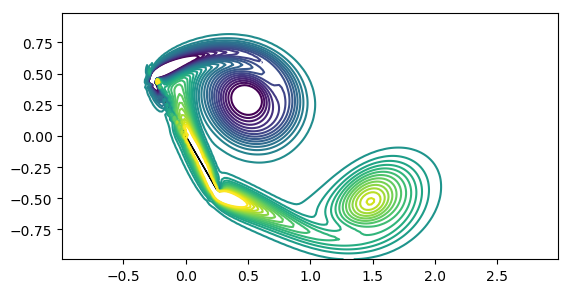

(-0.99, 2.99, -0.99, 0.99)

In [19]:
x = Grids.xcell(dom.grid)
y = Grids.ycell(dom.grid)

contour(x,y,s.u[dom.grid.cellint[1],dom.grid.cellint[2]]/Δx,linspace(-10,10,30))
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k")
end
axis("scaled")

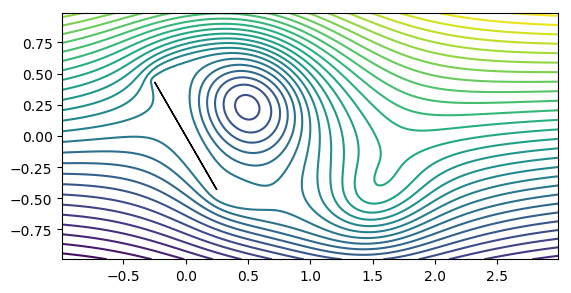

(-0.99, 2.99, -0.99, 0.99)

In [20]:
s.ψ = -L⁻¹(s.u)
contour(x,y,s.ψ[dom.grid.cellint[1],dom.grid.cellint[2]]*Δx+y,linspace(-1,1,31))
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k")
end
axis("scaled")